In [ ]:
# Directorio de trabajo
import sys
import os
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
DIR = "/content/drive/My Drive/bio/"

%cd "$DIR"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import dlib
import time
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from sklearn.metrics import plot_roc_curve

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

%matplotlib inline
%load_ext autoreload
%autoreload 2

seed = 2021
rng = np.random.default_rng(seed=seed)
simplefilter("ignore", category=ConvergenceWarning)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
_ = tf.device('/device:GPU:0')

In [4]:
train_dir = 'UADFV+TIMIT_faces_training/'
test_dir = 'CelebDF-Test/'
target_size = (160, 160)

In [5]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    class_mode='binary',
    batch_size=1,
    seed=seed,
    target_size=target_size,
    subset="training"
)

test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode='binary',
    batch_size=1,
    seed=seed,
    target_size=target_size,
)

num_train = train_data.samples
num_test = test_data.samples

Found 1829 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [6]:
# Load landmark detector
sp68 = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')

In [9]:
def preprocess(im, sigma):
    if rng.random() < 0.5:
        kernel_size = rng.choice([1, 3, 5, 7])
        im_noise = cv2.GaussianBlur(im, (kernel_size, kernel_size), 0)
    else:
        std = sigma*rng.random()
        noise = rng.normal(0, std, im.shape[:2])
        im_noise = im + np.tile(noise[:, :, None], (1, 1, 3))
    
    return im_noise


def shape_to_np(shape):
    number_of_points = shape.num_parts
    points = np.zeros((number_of_points, 2), dtype=np.int32)

    for i in range(number_of_points):
        points[i] = [shape.part(i).x, shape.part(i).y]

    return points


def get_crops_landmarks(im, sigma, blur, verbose):
    """
    Detects faces and landmarks in image, crops image to face region.
    We assume there is only one face on each dataset.
    """
    img = im.reshape(*im.shape[1:]).astype('uint8')

    # Add noise
    if blur:
        img_prec = preprocess(img, sigma=sigma).astype('uint8')
    else:
        img_prec = img

    # Detect landmarks and transform to np array
    face = dlib.rectangle(0, 0, 159, 159)  # our face crops are 160x160
    landmarks = shape_to_np(sp68(img_prec, face))
    gray = cv2.cvtColor(img_prec, cv2.COLOR_RGB2GRAY)

    # Truncate landmarks
    landmarks[landmarks < 0] = 0
    landmarks[landmarks > 159] = 159
    face_landmarks = gray[landmarks[:, 1], landmarks[:, 0]]

    # Plot images
    if verbose:
        cv2.rectangle(img, (0, 0), (159, 159), (0, 255, 0), 3)
        for (sX, sY) in landmarks:
            cv2.circle(img, (sX, sY), 1, (0, 0, 255), 2)
        plt.imshow(img)
        plt.show()

    # normalize landmarks
    face_landmarks = face_landmarks.astype(np.float64)
    face_landmarks -= face_landmarks.mean(axis=0)

    return face_landmarks


def extract_features(
    data_flow, 
    num_images, 
    sigma=3,
    blur=False,
    verbose=0,
    skip=True
):
    X = np.zeros((num_images, 68))  # 68 landmarks
    y = np.zeros(num_images,)

    i = 0
    for im, label in tqdm(data_flow):
        face_landmarks = \
            get_crops_landmarks(
                im, sigma=sigma, 
                blur=blur, verbose=verbose)

        X[i] = face_landmarks.flatten()
        y[i] = label

        i += 1
        if i >= num_images:
            break
        
    return X, y

In [ ]:
X_train, y_train = extract_features(train_data, num_train, blur=True)
print("X_train:", X_train.shape)
X_test, y_test = extract_features(test_data, num_test)
print("X_test:", X_test.shape)

In [ ]:
np.savez(
    'data3-ML', 
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test, 
    y_test=y_test
)

In [11]:
data3 = np.load('data3-ML.npz')
X_train, y_train = data3['X_train'], data3['y_train']
X_test, y_test = data3['X_test'], data3['y_test']

In [14]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Models
my_model = Pipeline([
    ('standardize', StandardScaler()),
    ('clf', SVC(
        kernel='rbf', 
        C=1.6681,
        gamma=0.0167,
        random_state=seed))])
name = "SVC"

[SVC] Acc Test Celeb-DF: 0.6233


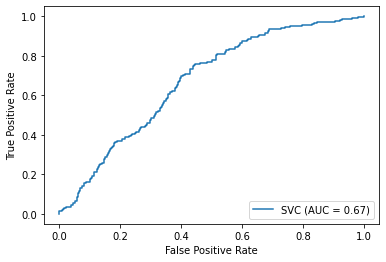

In [15]:
# Evaluate our model on the Celeb-DF test set
my_model.fit(X_train, y_train)
acc_test = my_model.score(X_test, y_test)
print(f"[{name}] Acc Test Celeb-DF: {acc_test:.4f}")
plot_roc_curve(my_model, X_test, y_test, name = name)
plt.show()